### IMDB Spoiler Dataset Overview

The IMDB Spoiler Dataset comprises two primary files, providing a comprehensive collection of user-generated reviews and metadata about movies and TV shows.

#### IMDB_reviews.json:

- **review_date:** Date when the review was written.
- **movie_id:** A unique identifier for the item, linking it to corresponding metadata in the IMDB_movie_details.json file.
- **user_id:** A unique identifier for the author of the review.
- **is_spoiler:** A binary indicator specifying whether the review contains spoilers or not.
- **review_text:** The textual content of the user's review, providing insights into their opinions and thoughts about the item.
- **rating:** The numerical rating assigned by the user to the item.
- **review_summary:** A concise summary accompanying the review, offering a quick overview of the user's sentiments.

#### IMDB_movie_details.json:

- **movie_id:** A unique identifier linking to the corresponding reviews in the IMDB_reviews file.
- **plot_summary:** A non-spoiler plot summary providing a brief overview of the item's storyline.
- **duration:** The runtime duration of the item.
- **genre:** The associated genres of the item.
- **rating:** The overall rating assigned to the item.
- **release_date:** The date when the item was released.
- **plot_synopsis:** A detailed synopsis of the item's plot, potentially containing spoiler content.

This dual-file dataset allows for a holistic understanding of user reviews, incorporating both textual sentiments and metadata associated with the movies and TV shows. The inclusion of spoiler indicators and non-spoiler plot summaries provides a valuable foundation for training and evaluating a deep learning model aimed at predicting and identifying spoilers within user reviews.


The **objective** of the project involves employing Natural Language Processing (NLP) techniques, specifically deep learning models, to address the challenge of identifying spoilers in IMDb reviews.

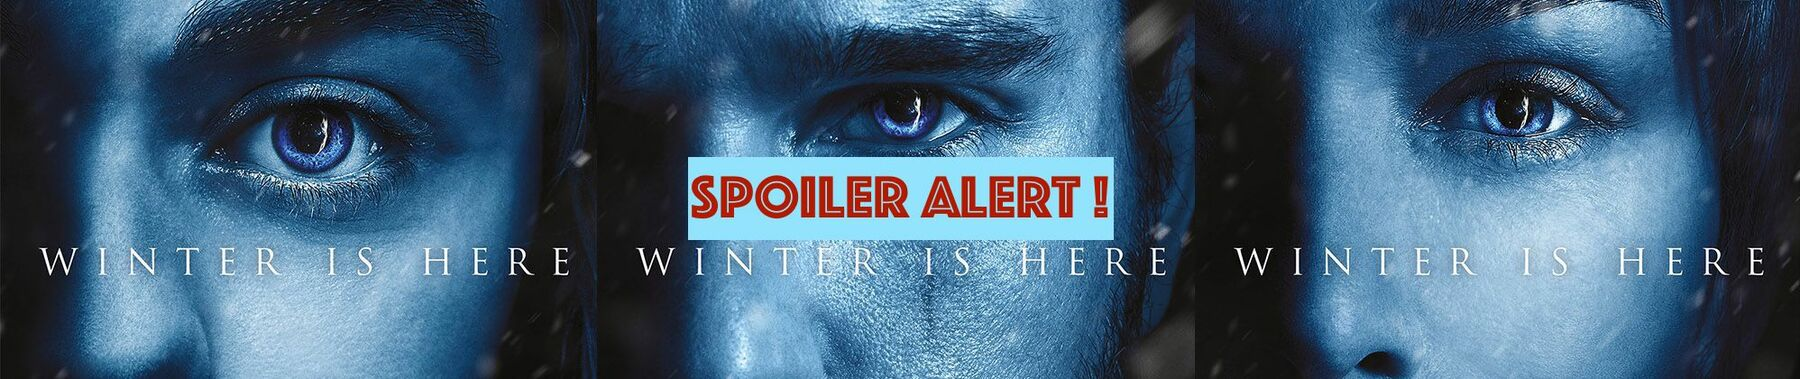

---




***This is where you come in!***  

Name:Balaji Gurusala
Email: balaji.gsb@gmail.com

**Problem Statement ->** Your goal is to develop a system wherein given a review, the model needs to determine whether it contains spoilers or not. This involves understanding the contextual nuances and language intricacies that signify potential plot revelations.


**Steps**
1. Data Collection, Exploration and Preprocessing
2. EDA
3. Pre-Modelling Data Preparation
4. Model Building
5. Model Evaluation
6. Summary



---



### This notebook cover Part 1 of 2 Spoiler shield mini project. Reason to split in to two parts is to accomodate large models like BERT to run independently and also accomodate exceptions that may arise from the colab environment. Part 2 covers the BERT model processing and results summary. This notebook coveres 1)DataCollection, Preprocessing 2)EDA 3)Data Preparation 4)Logistic regression, XGBoost, Nueral Network models building. Refer Part 2 for BERT Model building, Model Evaluation and Summary

In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install -U transformers huggingface_hub

## Data Collection, Exploration and Preprocessing

In [2]:
# ## 1. Data Collection

# Import necessary libraries and modules
import torch  # Import the PyTorch library
from datetime import datetime  # Import the datetime module for time tracking
import gdown
import zipfile
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
import os

In [6]:
import socket
try:
    socket.gethostbyname('drive.google.com')
    print("DNS resolution works")
except socket.gaierror:
    print("DNS resolution failed - network issue")

DNS resolution works


In [7]:
# ### Download Dataset
details_file_id = "1wkPlzRwOKSj3tjvX3wOnrSJj8iFPumqS"
reviews_file_id = "1hvzjvoGCwGMYyQ0tYj_FBnV-Ett0_ZTh"


dataset_path = os.path.join("./dataset", "imdb_spoiler") # the dataset will be downloaded in this folder
reviews_file_path = os.path.join(dataset_path, "IMDB_reviews.json")
details_file_path = os.path.join(dataset_path, "IMDB_movie_details.json")


if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

if not os.path.exists(reviews_file_path):
    gdown.download(id=reviews_file_id, output=reviews_file_path, quiet=False)

if not os.path.exists(details_file_path):
    gdown.download(id=details_file_id, output=details_file_path, quiet=False)

In [8]:
!head ./dataset/imdb_spoiler/IMDB_reviews.json

{"review_date": "10 February 2006", "movie_id": "tt0111161", "user_id": "ur1898687", "is_spoiler": true, "review_text": "In its Oscar year, Shawshank Redemption (written and directed by Frank Darabont, after the novella Rita Hayworth and the Shawshank Redemption, by Stephen King) was nominated for seven Academy Awards, and walked away with zero. Best Picture went to Forrest Gump, while Shawshank and Pulp Fiction were \"just happy to be nominated.\" Of course hindsight is 20/20, but while history looks back on Gump as a good film, Pulp and Redemption are remembered as some of the all-time best. Pulp, however, was a success from the word \"go,\" making a huge splash at Cannes and making its writer-director an American master after only two films. For Andy Dufresne and Co., success didn't come easy. Fortunately, failure wasn't a life sentence.After opening on 33 screens with take of $727,327, the $25M film fell fast from theatres and finished with a mere $28.3M. The reasons for failure ar

---


### **Load the Reviews Json file & create a pandas dataframe out of it**

Steps-
1. Open JSON file using 'with open .....'
2. Iterate through the file & append to an empty list.
3. Use pd.DataFrame

Note- This is one of the ways to load data, there can be other ways too. Feel free to explore.

In [9]:
data = []
with open(reviews_file_path, 'r') as file:
    for line in file:
        # Each line is a separate JSON object
        data.append(json.loads(line))

df_reviews = pd.DataFrame(data)

In [10]:
## check df shape, info, top 5 rows
df_reviews.shape


(573913, 7)

In [11]:
df_reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  object
 6   review_summary  573913 non-null  object
dtypes: bool(1), object(6)
memory usage: 26.8+ MB


In [12]:
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


### **Similarly, Load the Movie Details Json file & create a pandas dataframe out of it**

In [13]:
data = []
with open(details_file_path, 'r') as file:
    for line in file:
      data.append(json.loads(line))

df_details = pd.DataFrame(data)

In [14]:
## check df shape, info, top 5 rows
df_details.shape

(1572, 7)

In [15]:
df_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   movie_id       1572 non-null   object
 1   plot_summary   1572 non-null   object
 2   duration       1572 non-null   object
 3   genre          1572 non-null   object
 4   rating         1572 non-null   object
 5   release_date   1572 non-null   object
 6   plot_synopsis  1572 non-null   object
dtypes: object(7)
memory usage: 86.1+ KB


In [16]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


### **Combine the 2 datasets**

In [17]:
df_both = pd.merge(df_reviews, df_details, on='movie_id')

### **Explore the combined dataset**
Some of the EDA steps can be-
(Note- There can be more, what we have listed down is just a subset, feel free to explore the dataset more, get insights, find more relationships b/w features...)

### 1. Analyze Class Distribution

In [18]:
## Calculate Spoiler vs Non Spoiler % distribution
spoiler_count = df_both['is_spoiler'].value_counts().get(True, 0)
non_spoiler_count = df_both['is_spoiler'].value_counts().get(False, 0)
total_count = spoiler_count + non_spoiler_count
distribution = {
    'Spoiler': spoiler_count / total_count,
    'Non Spoiler': non_spoiler_count / total_count
}

print(distribution)

{'Spoiler': 0.2629768638069649, 'Non Spoiler': 0.7370231361930351}


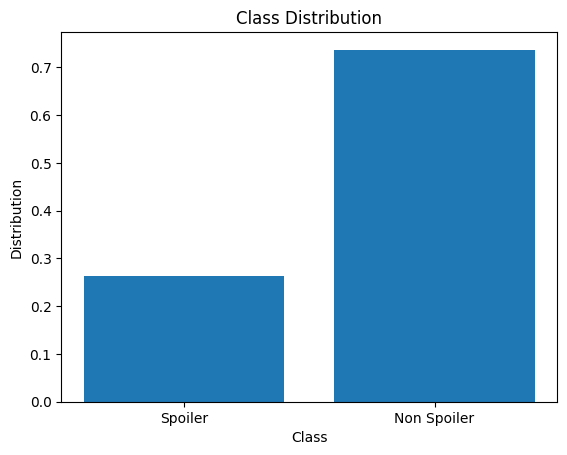

In [19]:
## Plot bar chart
plt.bar(distribution.keys(), distribution.values())
plt.xlabel('Class')
plt.ylabel('Distribution')
plt.title('Class Distribution')
plt.show()

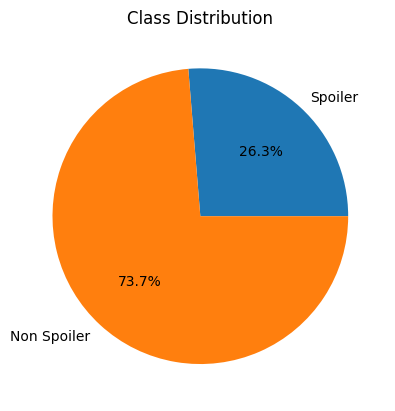

In [20]:
#pie chart
plt.pie(distribution.values(), labels=distribution.keys(), autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

### 2. Analyze Word Count Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


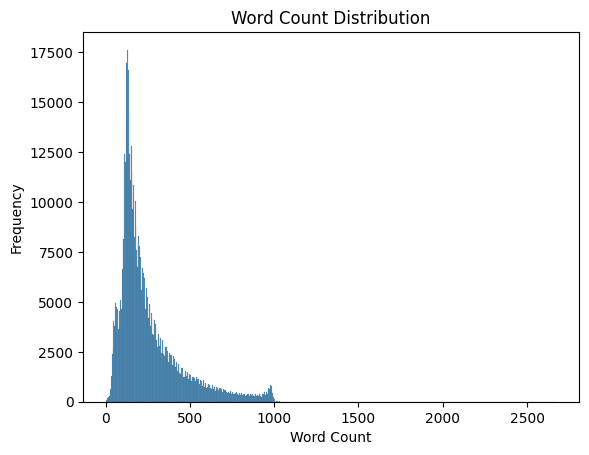

In [21]:
## Plot appropriate chart for the frequency distribution of no. of words in every review
df_both['word_count'] = df_both['review_text'].apply(lambda x: len(x.split()))
sns.histplot(df_both['word_count'])
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.show()


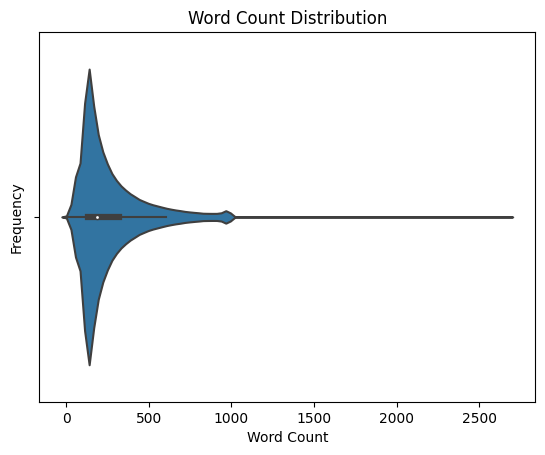

In [22]:
#violin plot
sns.violinplot(x=df_both['word_count'])
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.show()

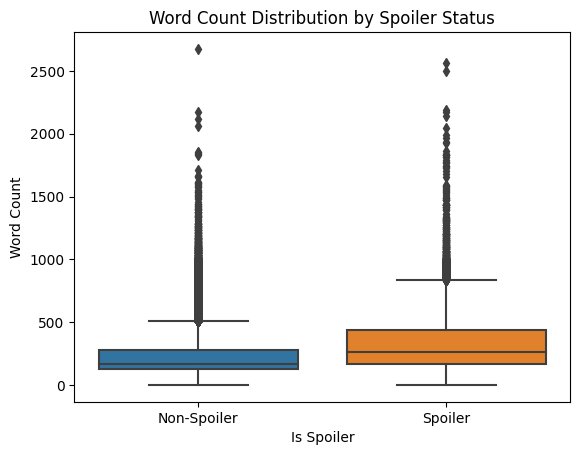

In [23]:
sns.boxplot(x='is_spoiler', y='word_count', data=df_both)
plt.xlabel('Is Spoiler')
plt.ylabel('Word Count')
plt.title('Word Count Distribution by Spoiler Status')
plt.xticks([0, 1], ['Non-Spoiler', 'Spoiler'])
plt.show()

### Additional note- You can also plot the above frequency distribution for each class, i.e. Spoiler & Non Spoiler

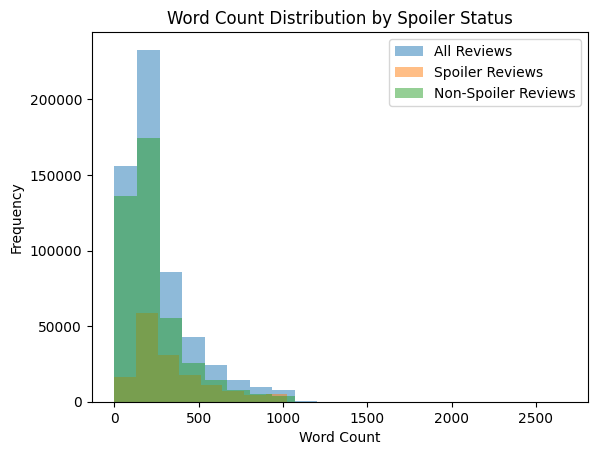

In [24]:
#Histogram plot for frequency distribution of spoiler and non spoiler reviews
plt.hist(df_both['word_count'], bins=20, alpha=0.5, label='All Reviews')
plt.hist(df_both[df_both['is_spoiler'] == True]['word_count'], bins=20, alpha=0.5, label='Spoiler Reviews')
plt.hist(df_both[df_both['is_spoiler'] == False]['word_count'], bins=20, alpha=0.5, label='Non-Spoiler Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution by Spoiler Status')
plt.legend()
plt.show()

**Observations**

*Document your observations for the analysis done till now, any findings, insights etc.*

- The dataset is imbalanced where non spoiler reviews (73.7%)dominate compared to spoiler reviews (26.3%). This means, when splitting train/test sets, we must ensure the proportions remain similar to avoid bias.
- From the histogram of word counts, it clearly shows that the data is right skwered. The majority of the sample have a lower word count (most below 500). Peak is around 200 word counts. Violin plot confirms the dense concentration of samples with low word counts. It also shows spread with a long tail.
- Box plot shows both "Spoiler" and "Non Spoiler" classes show a wide range of word counts, with a lot of outliers. The median word count for "Spoiler" samples are noticeably higher than the "Non Spoiler" samples. The distribution for "Spoiler" is shifted right (more words), which means spoiler posts tend to be longer

**Model Impact**

- Word count could be a useful feature in the model, as there's a clear correlation between higher word counts and the presence of spoilers. Can this be used along with review_text?

### 3. Create a word cloud
This helps in visualizing important words in the dataset, the words that are being mostly used.

**Hint**- You would want to ideally remove the stopwords before creating a word cloud since the stopwords generally would be the most frequent words but those don't give any insights, right? Also, you can create word clouds for both the classes!

In [26]:
## remove stopwords- use nltk or spacy for that
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Ensure stop_words is a list before extending
stop_words = list(stop_words)
stop_words.extend(['@',"'",'.','"','/','!',',',"'ve","...","n't",'$',"'s",'''"''',"''",'..','&','*',';','”','``',':','#','!','-','?','%',"'d","'m",'+','++'])

In [28]:
review_spoiler = ' '.join(df_both[df_both['is_spoiler'] == True]['review_text'])
review_non_spoiler = ' '.join(df_both[df_both['is_spoiler'] == False]['review_text'])

In [29]:
len(review_spoiler)


285046646

In [30]:
len(review_non_spoiler)

553751681

In [32]:
## create wordcloud for both the classes & visualize
from wordcloud import WordCloud
from collections import Counter

# Limit to top words using the max_words parameter!
wc_params = {
    "width": 600,             # Smaller image size
    "height": 300,
    "background_color": "white",
    "max_words": 200,         # Only the 200 most common words
    "stopwords": stop_words
}

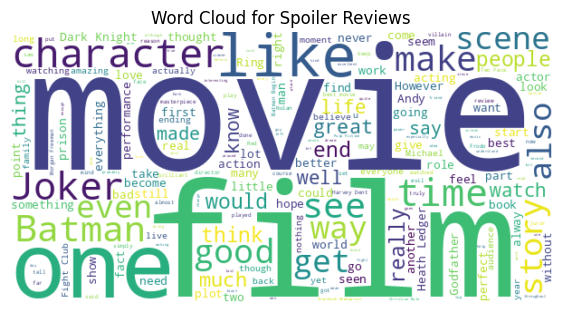

In [33]:
# For Spoiler Reviews
wordcloud_spoiler = WordCloud(**wc_params).generate(review_spoiler[:10000000])
plt.figure(figsize=(7, 4))
plt.imshow(wordcloud_spoiler, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Spoiler Reviews")
plt.show()

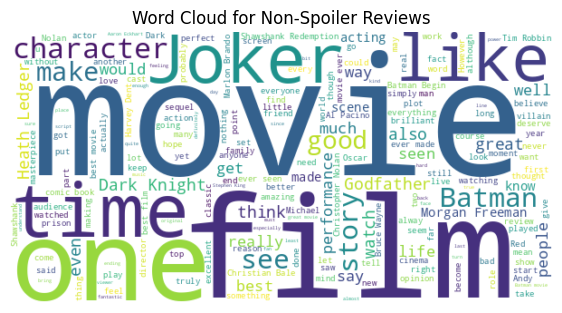

In [34]:
# Create wordcloud for non-spoiler reviews
wordcloud_non_spoiler = WordCloud(**wc_params).generate(review_non_spoiler[:10000000])
plt.figure(figsize=(7, 4))
plt.imshow(wordcloud_non_spoiler, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Non-Spoiler Reviews')
plt.show()

**Observations from Word Count**
- These plots confirm that both spoiler and non-spoiler reviews share many frequent words and movie-specific terms, but spoiler reviews may offer more references to plot events, endings, or character arcs—yet these differences are subtle at the unigram level. Further feature engineering or NLP analysis will be needed for best-classifying spoilers.

### 4. Calculate similarity b/w reviews & plot summary
The hypothesis we're trying to test here- is there a similarity b/w the reviews with spoilers & movie plot summary? Intuitively we would expect that if a user has given a spoiler in a movie review, it should have a high similarity with the movie plot, isn't it? That's exactly what you would test here!

There are multiple ways of calculating similarity b/w 2 sets of text-

1. Using TFIDF vectorization
2. Using Pretrained-embeddings
.
.

We are sharing the imports necessary for using TFIDF vectorization for converting text to vectors.

In [35]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

What next after converting text to vectors? How do we measure the similarity? Again we have different types of similarity measures. One of them is cosine similarity & is probably the most frequent method used for similarity. Reference- https://medium.com/@ahmetmnirkocaman/how-to-measure-text-similarity-a-comprehensive-guide-6c6f24fc01fe

In [37]:
# Group spoiler reviews by movie_id
grouped_spoiler_reviews = df_both[df_both['is_spoiler'] == True].groupby('movie_id')

# Group movie details by movie_id
grouped_movie_details = df_details.groupby('movie_id')

In [38]:
grouped_spoiler_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,word_count
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",843
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",223
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",250
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",741
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573622,1 April 2005,tt0139239,ur3922673,True,"There are several kinds of movies that I like,...",8,"It didn't make too much sense at first, but I ...","Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",452
573623,14 September 2003,tt0139239,ur1532177,True,I saw this last night and I was going to prais...,6,Rather Shallow,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",491
573624,2 September 2007,tt0139239,ur1609501,True,"After the success of ""Swingers"", director Doug...",9,Excellent black comedy told via three interloc...,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",490
573625,8 June 2017,tt0139239,ur1616919,True,The unmistakable influence of Pulp Fiction (19...,8,Very fun 90's comic crime caper,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",350


Check if same user_id has multiple reviews for the same movie_id

In [39]:
duplicates = df_both.duplicated(subset=['movie_id', 'user_id'], keep=False)
df_both[duplicates][['movie_id', 'user_id', 'review_text']]

,movie_id,user_id,review_text


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
similarity_scores_spoiler = {}

for movie_id, spoiler_reviews_group in grouped_spoiler_reviews:
    # Get the plot summary for the current movie
    plot_summary_group = grouped_movie_details.get_group(movie_id)['plot_summary']

    if not spoiler_reviews_group.empty and not plot_summary_group.empty:
        # Combine reviews and plot summary text for fitting the vectorizer
        combined_text = list(spoiler_reviews_group['review_text']) + list(plot_summary_group)

        # Fit a single TF-IDF vectorizer on the combined text
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
        tfidf_vectorizer.fit(combined_text)

        # Transform reviews and plot summary using the fitted vectorizer
        movie_reviews_tfidf = tfidf_vectorizer.transform(spoiler_reviews_group['review_text'])
        movie_plot_tfidf = tfidf_vectorizer.transform(plot_summary_group)

        # --- Calculate Cosine Similarity ---
        # Calculate the cosine similarity here between movie_reviews_tfidf and movie_plot_tfidf
        similarity = cosine_similarity(movie_reviews_tfidf, movie_plot_tfidf)

         # Mean, max, and 90th-percentile similarity scores
        similarity_scores_spoiler[movie_id] = {
            'mean': similarity.mean(),
            'max': similarity.max(),
            'p90': np.percentile(similarity, 90)
        }

        # Save similarity score for each review
        for seq_idx, (row_idx, row) in enumerate(spoiler_reviews_group.iterrows()):
            key = (str(row['movie_id']).strip(), str(row['user_id']).strip())
            similarity_scores_spoiler[key] = {
                'movie_id': row['movie_id'],
                'user_id': row['user_id'],
                'similarity_to_plot': similarity[seq_idx, 0]  # Use zero-based sequence index
            }

In [42]:
print(similarity_scores_spoiler['tt0012349', 'ur22131361'])

{'movie_id': 'tt0012349', 'user_id': 'ur22131361', 'similarity_to_plot': 0.032255263456373015}


In [43]:
grouped_non_spoiler_reviews = df_both[df_both['is_spoiler'] == False].groupby('movie_id')

In [44]:
similarity_scores_non_spoiler = {}

for movie_id, non_spoiler_reviews_group in grouped_non_spoiler_reviews:
    # Get the plot summary for the current movie
    plot_summary_group = grouped_movie_details.get_group(movie_id)['plot_summary']

    if not non_spoiler_reviews_group.empty and not plot_summary_group.empty:
        # Combine reviews and plot summary text for fitting the vectorizer
        combined_text = list(non_spoiler_reviews_group['review_text']) + list(plot_summary_group)

        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
        tfidf_vectorizer.fit(combined_text)

        movie_reviews_tfidf = tfidf_vectorizer.transform(non_spoiler_reviews_group['review_text'])
        movie_plot_tfidf = tfidf_vectorizer.transform(plot_summary_group)

        # Calculate the cosine similarity here between movie_reviews_tfidf and movie_plot_tfidf
        similarity = cosine_similarity(movie_reviews_tfidf, movie_plot_tfidf)

        similarity_scores_non_spoiler[movie_id] = {
            'mean': similarity.mean(),
            'max': similarity.max(),
            'p90': np.percentile(similarity, 90)
        }

        # Save similarity score for each review
        for seq_idx, (row_idx, row) in enumerate(non_spoiler_reviews_group.iterrows()):
            key = (str(row['movie_id']).strip(), str(row['user_id']).strip())
            similarity_scores_non_spoiler[key] = {
                'movie_id': row['movie_id'],
                'user_id': row['user_id'],
                'similarity_to_plot': similarity[seq_idx, 0]  # Use zero-based sequence index
            }


In [45]:
i = 0
for key in similarity_scores_non_spoiler:
    print(key, similarity_scores_non_spoiler[key])
    i = i+1
    if i == 10:
        break

tt0012349 {'mean': 0.023840253479409247, 'max': 0.16114704228167379, 'p90': 0.04073215355642709}
('tt0012349', 'ur4445210') {'movie_id': 'tt0012349', 'user_id': 'ur4445210', 'similarity_to_plot': 0.012025850478286283}
('tt0012349', 'ur2142676') {'movie_id': 'tt0012349', 'user_id': 'ur2142676', 'similarity_to_plot': 0.006366869346568467}
('tt0012349', 'ur9972457') {'movie_id': 'tt0012349', 'user_id': 'ur9972457', 'similarity_to_plot': 0.028397024496323024}
('tt0012349', 'ur0453068') {'movie_id': 'tt0012349', 'user_id': 'ur0453068', 'similarity_to_plot': 0.038286192266490396}
('tt0012349', 'ur3063013') {'movie_id': 'tt0012349', 'user_id': 'ur3063013', 'similarity_to_plot': 0.03347145204877705}
('tt0012349', 'ur0562732') {'movie_id': 'tt0012349', 'user_id': 'ur0562732', 'similarity_to_plot': 0.03885712338775947}
('tt0012349', 'ur14892110') {'movie_id': 'tt0012349', 'user_id': 'ur14892110', 'similarity_to_plot': 0.0028746089402399426}
('tt0012349', 'ur2483625') {'movie_id': 'tt0012349', 'u

**Simialirty between review text spoilers and plot summary**

In [46]:
df_both['similarity_to_plot'] = df_both.apply(
    lambda row: (
        similarity_scores_spoiler.get((row['movie_id'], row['user_id']), {}).get('similarity_to_plot')
        or similarity_scores_non_spoiler.get((row['movie_id'], row['user_id']), {}).get('similarity_to_plot')
        or np.nan
    ),
    axis=1
)

In [47]:
df_both.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,word_count,similarity_to_plot
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",843,0.016612
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",223,0.012685
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",250,0.016893
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",741,0.018187
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",829,0.017087


**Plots for Spoiler/Non Spoiler reviews and it's similarities to plot summary**

In [48]:
print("Spoilers: Mean", df_both[df_both['is_spoiler']]['similarity_to_plot'].mean())
print("Non-Spoilers: Mean", df_both[~df_both['is_spoiler']]['similarity_to_plot'].mean())

Spoilers: Mean 0.023685290188103354
Non-Spoilers: Mean 0.018275959678924685


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


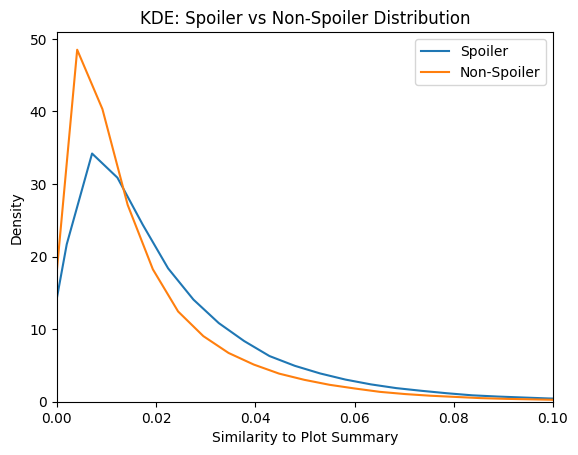

In [49]:
import seaborn as sns
sns.kdeplot(df_both[df_both['is_spoiler']]['similarity_to_plot'].dropna(), label='Spoiler')
sns.kdeplot(df_both[~df_both['is_spoiler']]['similarity_to_plot'].dropna(), label='Non-Spoiler')
plt.xlim(0, 0.1)
plt.xlabel('Similarity to Plot Summary')
plt.title('KDE: Spoiler vs Non-Spoiler Distribution')
plt.legend()
plt.show()

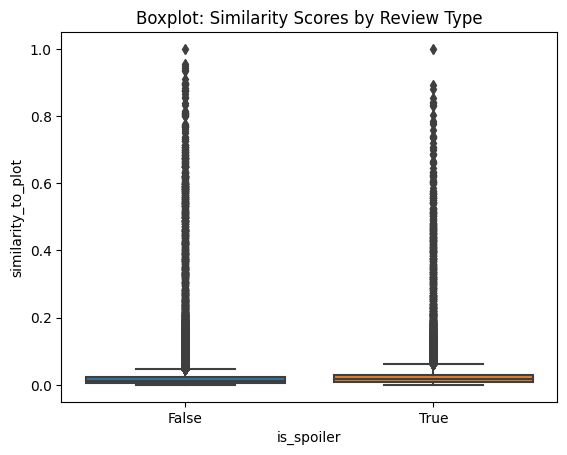

In [50]:
import seaborn as sns

sns.boxplot(data=df_both, x='is_spoiler', y='similarity_to_plot')
plt.title('Boxplot: Similarity Scores by Review Type')
plt.show()

In [51]:
#Compare movie level Similarity scores

# Extract mean values at movie level only 
spoiler_means = [v['mean'] for k, v in similarity_scores_spoiler.items() if isinstance(k, str)]
non_spoiler_means = [v['mean'] for k, v in similarity_scores_non_spoiler.items() if isinstance(k, str)]

# Compute statistics
print(f"Spoiler Reviews - Mean Similarity: {np.mean(spoiler_means):.4f} (±{np.std(spoiler_means):.4f})")
print(f"Non-Spoiler Reviews - Mean Similarity: {np.mean(non_spoiler_means):.4f} (±{np.std(non_spoiler_means):.4f})")
print(f"Difference: {np.mean(spoiler_means) - np.mean(non_spoiler_means):.4f}")

Spoiler Reviews - Mean Similarity: 0.0285 (±0.0135)
Non-Spoiler Reviews - Mean Similarity: 0.0184 (±0.0074)
Difference: 0.0101


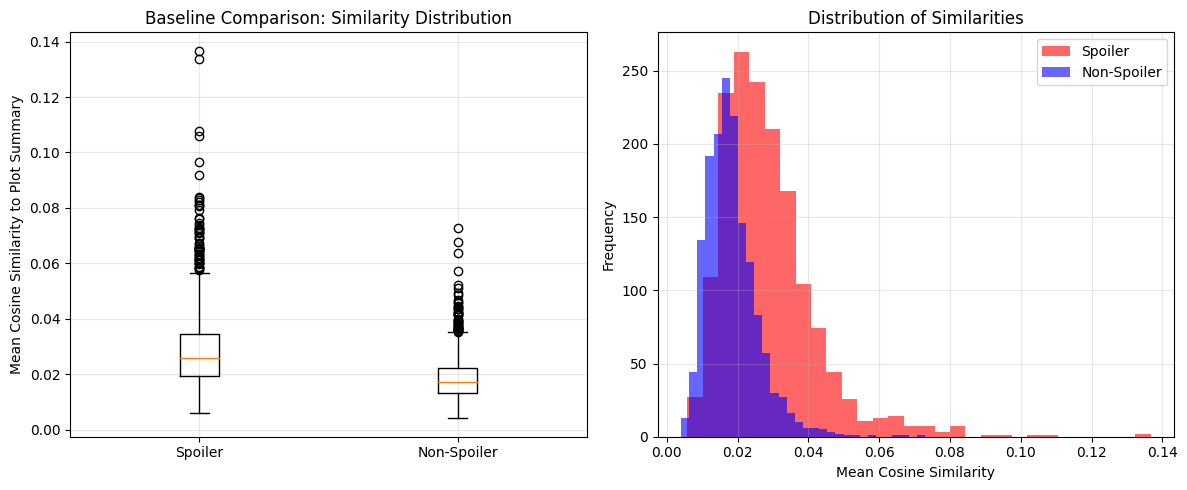

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot comparison
axes[0].boxplot([spoiler_means, non_spoiler_means], labels=['Spoiler', 'Non-Spoiler'])
axes[0].set_ylabel('Mean Cosine Similarity to Plot Summary')
axes[0].set_title('Baseline Comparison: Similarity Distribution')
axes[0].grid(True, alpha=0.3)

# Histogram comparison
axes[1].hist(spoiler_means, bins=30, alpha=0.6, label='Spoiler', color='red')
axes[1].hist(non_spoiler_means, bins=30, alpha=0.6, label='Non-Spoiler', color='blue')
axes[1].set_xlabel('Mean Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Similarities')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Cosine Similarity Observations**

- Spoilers are slighlty more Similar to Plot Summaries. Spoiler reviews have 0.0285 mean similarity vs. 0.0184 for non-spoilers.
- From the KDE density plot, both spoiler and non-spoiler reviews peak at very low similarity values (<0.02). Spoiler curve (blue) sits slightly higher than     the non spoiler curve in the right tail.we can focus on reviews in the higher similarity tail (e.g. above 0.05) for manual inspection, thresholding, or        rule-based flagging.
- From the similarity scores box plot, both spoler and non spoler reviews are heavily skewed towards zero. Both groups have outliers with very high similarity   (potential duplicates or reviews copying the plot summary)
- From the movie level similarity box plot, Spoiler reviews show a higher median similarity (~0.028) with clear outliers reaching up to ~0.14.The boxes don't overlap, confirming a clear separation between the two classes.
- The presence of outliers in both groups suggests some reviews have exceptionally high similarity to plot summaries (likely detailed plot discussions).
- From the histogram plot, Spoiler distribution (red) is shifted right compared to non-spoiler (blue), confirming spoilers have higher overall similarity.
- Some non-spoiler reviews occasionally match plot summaries (possibly discussing general themes or character arcs without revealing specifics).





**Cosine Similarity Using sentence Transformer**


In [53]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device() 

In [54]:
print(device)

cuda


In [55]:
from sentence_transformers import SentenceTransformer

# Load a pretrained sentence transformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

2025-11-05 02:39:40.033616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762310380.245196     112 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762310380.302102     112 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [56]:
# Process SPOILER reviews
from tqdm import tqdm
import time

total_time = 0
similarity_scores_embeddings_spoiler = {}
for movie_id, spoiler_reviews_group in tqdm(grouped_spoiler_reviews, desc='Processing movies', unit='movie'):
    plot_summary_group = grouped_movie_details.get_group(movie_id)['plot_summary']

    if not spoiler_reviews_group.empty and not plot_summary_group.empty:
        start = time.time()
        # Encode reviews and plot summary
        review_embeddings = model.encode(spoiler_reviews_group['review_text'].values, convert_to_numpy=True, 
                                         batch_size=32, show_progress_bar=False)
        plot_embeddings = model.encode(plot_summary_group.values, convert_to_numpy=True, 
                                       batch_size=32, show_progress_bar=False)

        # Compute cosine similarity
        similarity = cosine_similarity(review_embeddings, plot_embeddings)

        similarity_scores_embeddings_spoiler[movie_id] = {
            'mean': similarity.mean(),
            'max': similarity.max(),
            'p90': np.percentile(similarity, 90)
        }

        # Save similarity score for each review
        for seq_idx, (row_idx, row) in enumerate(spoiler_reviews_group.iterrows()):
            key = (str(row['movie_id']).strip(), str(row['user_id']).strip())
            similarity_scores_embeddings_spoiler[key] = {
                'movie_id': row['movie_id'],
                'user_id': row['user_id'],
                'similarity_to_plot': similarity[seq_idx, 0]  # Use zero-based sequence index
            }
        total_time += time.time() - start
        
print(f"\n✓ Total model encoding time: {total_time:.2f}s")

Processing movies: 100%|██████████| 1570/1570 [08:37<00:00,  3.03movie/s]


✓ Total model encoding time: 516.04s


In [57]:
# Process NON-SPOILER reviews (BASELINE)
from tqdm import tqdm
import time

total_time = 0
similarity_scores_embeddings_non_spoiler = {}
for movie_id, non_spoiler_reviews_group in tqdm(grouped_non_spoiler_reviews, desc='Processing movies', unit='movie'):
    plot_summary_group = grouped_movie_details.get_group(movie_id)['plot_summary']

    if not non_spoiler_reviews_group.empty and not plot_summary_group.empty:
        start = time.time()
        
        review_embeddings = model.encode(non_spoiler_reviews_group['review_text'].values, 
                                         convert_to_numpy=True, batch_size=32, show_progress_bar=False)
        plot_embeddings = model.encode(plot_summary_group.values, convert_to_numpy=True,
                                       batch_size=32, show_progress_bar=False)

        similarity = cosine_similarity(review_embeddings, plot_embeddings)

        similarity_scores_embeddings_non_spoiler[movie_id] = {
            'mean': similarity.mean(),
            'max': similarity.max(),
            'p90': np.percentile(similarity, 90)
        }

        # Save similarity score for each review
        for seq_idx, (row_idx, row) in enumerate(non_spoiler_reviews_group.iterrows()):
            key = (str(row['movie_id']).strip(), str(row['user_id']).strip())
            similarity_scores_embeddings_non_spoiler[key] = {
                'movie_id': row['movie_id'],
                'user_id': row['user_id'],
                'similarity_to_plot': similarity[seq_idx, 0]  
            }
        total_time += time.time() - start

print(f"\n✓ Total model encoding time: {total_time:.2f}s")

Processing movies: 100%|██████████| 1570/1570 [20:00<00:00,  1.31movie/s]


✓ Total model encoding time: 1198.90s


In [58]:
df_both['embeddings_similarity_to_plot'] = df_both.apply(
    lambda row: (
        similarity_scores_embeddings_spoiler.get((row['movie_id'], row['user_id']), {}).get('similarity_to_plot')
        or similarity_scores_embeddings_non_spoiler.get((row['movie_id'], row['user_id']), {}).get('similarity_to_plot')
        or np.nan
    ),
    axis=1
)

In [59]:
print("Embeddings Spoilers: Mean", df_both[df_both['is_spoiler']]['embeddings_similarity_to_plot'].mean())
print("Embeddings Non-Spoilers: Mean", df_both[~df_both['is_spoiler']]['embeddings_similarity_to_plot'].mean())

Embeddings Spoilers: Mean 0.39242128
Embeddings Non-Spoilers: Mean 0.34343305


In [60]:
df_both[df_both['is_spoiler']]['embeddings_similarity_to_plot']

0         0.512277
1         0.720940
2         0.737935
3         0.280551
4         0.643839
            ...   
573633    0.301408
573634    0.202793
573635    0.343525
573636    0.218407
573637    0.111766
Name: embeddings_similarity_to_plot, Length: 150924, dtype: float32

**KDE Density plot for Embeddings Spoiler vs Non-Spoiler distribution**

In [61]:
df_both[~df_both['is_spoiler']]['embeddings_similarity_to_plot']

956       0.557876
957       0.565641
958       0.600674
959       0.584565
960       0.733002
            ...   
573901    0.250680
573902    0.389970
573903    0.149696
573904    0.158114
573905    0.463408
Name: embeddings_similarity_to_plot, Length: 422982, dtype: float32

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


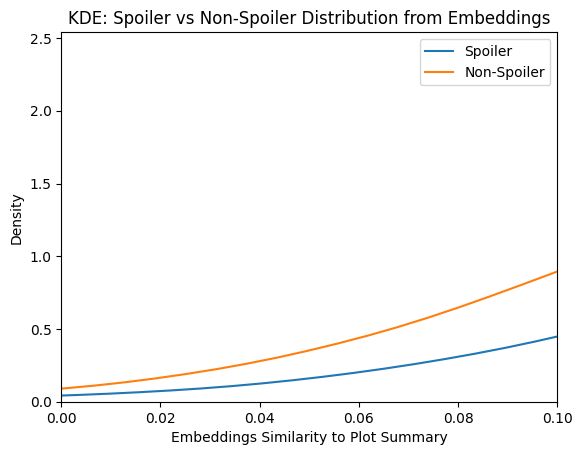

In [62]:
import seaborn as sns
sns.kdeplot(df_both[df_both['is_spoiler']]['embeddings_similarity_to_plot'].dropna(), label='Spoiler')
sns.kdeplot(df_both[~df_both['is_spoiler']]['embeddings_similarity_to_plot'].dropna(), label='Non-Spoiler')
plt.xlim(0, 0.1)
plt.xlabel('Embeddings Similarity to Plot Summary')
plt.title('KDE: Spoiler vs Non-Spoiler Distribution from Embeddings')
plt.legend()
plt.show()


**Box plot for Embeddings Spoiler Vs Non-Spoiler distribution**

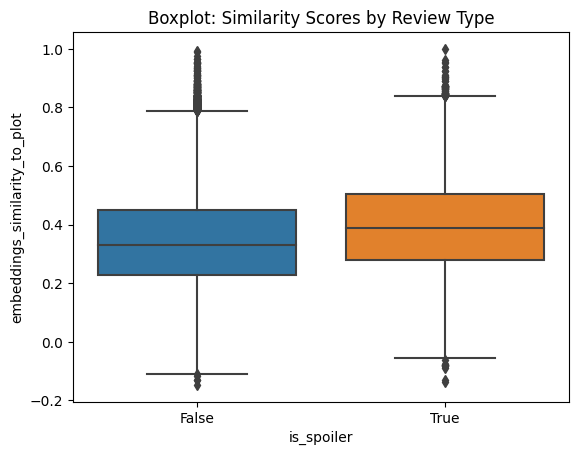

In [63]:
import seaborn as sns

sns.boxplot(data=df_both, x='is_spoiler', y='embeddings_similarity_to_plot')
plt.title('Boxplot: Similarity Scores by Review Type')
plt.show()


In [64]:
#Compare movie level Embeddings Similarity scores

# Extract mean values at movie level only 
embedding_spoiler_means = [v['mean'] for k, v in similarity_scores_embeddings_spoiler.items() if isinstance(k, str)]
embedding_non_spoiler_means = [v['mean'] for k, v in similarity_scores_embeddings_non_spoiler.items() if isinstance(k, str)]

# Compute statistics
print(f"Spoiler Reviews - Mean Similarity: {np.mean(embedding_spoiler_means):.4f} (±{np.std(spoiler_means):.4f})")
print(f"Non-Spoiler Reviews - Mean Similarity: {np.mean(embedding_non_spoiler_means):.4f} (±{np.std(non_spoiler_means):.4f})")
print(f"Difference: {np.mean(embedding_spoiler_means) - np.mean(embedding_non_spoiler_means):.4f}")


Spoiler Reviews - Mean Similarity: 0.4014 (±0.0135)
Non-Spoiler Reviews - Mean Similarity: 0.3469 (±0.0074)
Difference: 0.0546


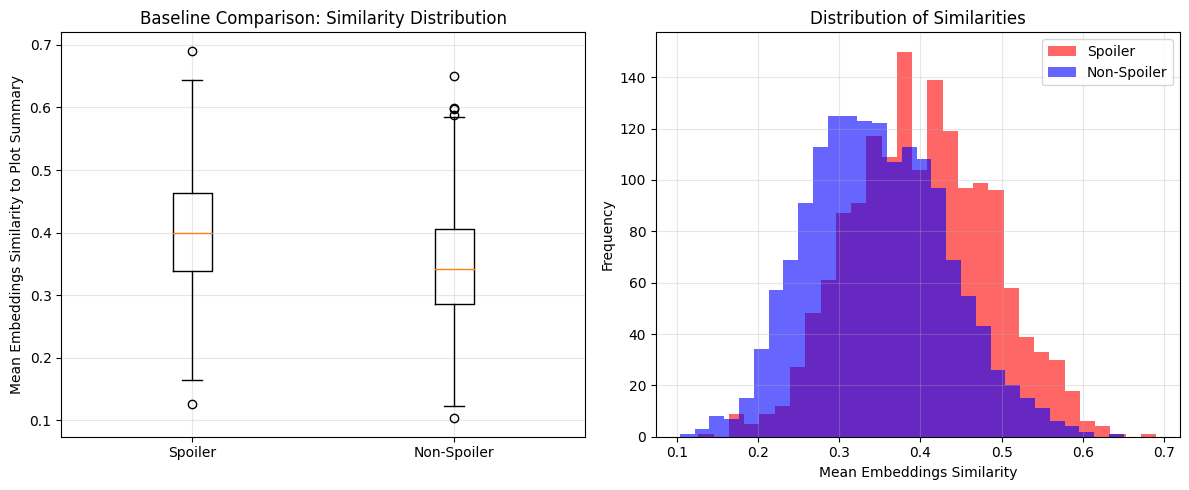

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot comparison
axes[0].boxplot([embedding_spoiler_means, embedding_non_spoiler_means], labels=['Spoiler', 'Non-Spoiler'])
axes[0].set_ylabel('Mean Embeddings Similarity to Plot Summary')
axes[0].set_title('Baseline Comparison: Similarity Distribution')
axes[0].grid(True, alpha=0.3)

# Histogram comparison
axes[1].hist(embedding_spoiler_means, bins=30, alpha=0.6, label='Spoiler', color='red')
axes[1].hist(embedding_non_spoiler_means, bins=30, alpha=0.6, label='Non-Spoiler', color='blue')
axes[1].set_xlabel('Mean Embeddings Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Similarities')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Embeddings Similarity to Plot Summary Observation**

- Embeddings Spoilers: Mean 0.39 vs Embeddings Non-Spoilers: Mean 0.34 is slightly higher and closer to movie plot summary. However, non spoilers also seems to follow the same trend, but can we use this difference to identify spolers in the review text? Check other plots for this decision!
- From the KDE Embeddings density plot, Non-spoilers dominate high similarity values with movie plot summary. This means relying on cosine similarity or Embeddings similarity to detect spoilers in the review text may not be a good idea!
- From the Embeddings box plot, Clear Separation at Median Level. The spoilers (True) have a noticeably higher median (~0.40) compared to non-spoilers (False, ~0.33). Despite the median difference, the boxes significantly overlap. Many non-spoiler reviews have embeddings similarity scores in the same range as spoilers, and vice versa.
- From the frequency distribution plot, results are consistent with mean calculations. Further evaluation is required to use embeddings similarity for spoiler identification.

### This completes the EDA part. We would highly encourage you to add more subsections to EDA & explore the data in more depth, if you have more time. Let's get down to Text preprocessing & then the modeling part!!

Steps-
1. Analyze & observe the patterns in text, because data cleaning depends a lot on your use case.
2. Remove special characters, any hyperlinks etc. Pls note that sometimes special characters like ! etc. can also add to the context, so remove the special characters accordingly.
3. Remove stopwords, again depending on your text corpus.


In [67]:
# Analyze & observe the patterns in text, because data cleaning depends a lot on your use case.
df_both.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,word_count,similarity_to_plot,embeddings_similarity_to_plot
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",843,0.016612,0.512277
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",223,0.012685,0.720940
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",250,0.016893,0.737935
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",741,0.018187,0.280551
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",829,0.017087,0.643839


In [68]:
df_both['review_text'][0]

'In its Oscar year, Shawshank Redemption (written and directed by Frank Darabont, after the novella Rita Hayworth and the Shawshank Redemption, by Stephen King) was nominated for seven Academy Awards, and walked away with zero. Best Picture went to Forrest Gump, while Shawshank and Pulp Fiction were "just happy to be nominated." Of course hindsight is 20/20, but while history looks back on Gump as a good film, Pulp and Redemption are remembered as some of the all-time best. Pulp, however, was a success from the word "go," making a huge splash at Cannes and making its writer-director an American master after only two films. For Andy Dufresne and Co., success didn\'t come easy. Fortunately, failure wasn\'t a life sentence.After opening on 33 screens with take of $727,327, the $25M film fell fast from theatres and finished with a mere $28.3M. The reasons for failure are many. Firstly, the title is a clunker. While iconic to fans today, in 1994, people knew not and cared not what a \'Shaws

In [5]:
df_both.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,word_count,similarity_to_plot,embeddings_similarity_to_plot
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",843,0.016612,0.512277
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",223,0.012685,0.720940
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",250,0.016893,0.737935
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",741,0.018187,0.280551
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",829,0.017087,0.643839


### Start with removing stop words, then sentence tokenization, and then Stemming or lemmatization.We can leave the review_text as is in the df_both data frame and create a new column

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download required NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_review_text(text):
    """
    Complete text preprocessing pipeline:
    1. Lowercase conversion
    2. Remove special characters/punctuation
    3. Sentence tokenization
    4. Word tokenization
    5. Stop words removal
    6. Lemmatization
    """
    
    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Remove URLs, special characters, extra whitespace
    text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 3. Sentence tokenization
    sentences = sent_tokenize(text)
    
    # 4. Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # 5. Process each sentence
    processed_sentences = []
    stop_words = set(stopwords.words('english'))
    
    for sentence in sentences:
        # Word tokenization
        words = word_tokenize(sentence)
        
        # Remove stop words and lemmatize
        processed_words = [
            lemmatizer.lemmatize(word)
            for word in words 
            if word not in stop_words and len(word) > 1
        ]
        
        processed_sentences.append(' '.join(processed_words))
    
    # Return as single string
    return ' '.join(processed_sentences)

# Apply to your dataframe
df_both['review_text_processed'] = df_both['review_text'].apply(preprocess_review_text)

# Display results
print(df_both[['review_text', 'review_text_processed']].head())

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                         review_text  \
0  In its Oscar year, Shawshank Redemption (writt...   
1  The Shawshank Redemption is without a doubt on...   
2  I believe that this film is the best story eve...   
3  **Yes, there are SPOILERS here**This film has ...   
4  At the heart of this extraordinary movie is a ...   

                               review_text_processed  
0  oscar year shawshank redemption written direct...  
1  shawshank redemption without doubt one brillia...  
2  believe film best story ever told film tell ti...  
3  yes spoiler film emotional impact find hard wr...  
4  heart extraordinary movie brilliant indelible ...  


In [7]:
df_both.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,word_count,similarity_to_plot,embeddings_similarity_to_plot,review_text_processed
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",843,0.016612,0.512277,oscar year shawshank redemption written direct...
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",223,0.012685,0.720940,shawshank redemption without doubt one brillia...
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",250,0.016893,0.737935,believe film best story ever told film tell ti...
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",741,0.018187,0.280551,yes spoiler film emotional impact find hard wr...
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",829,0.017087,0.643839,heart extraordinary movie brilliant indelible ...


### **Model Training - Tips and Tricks**
- Since the dataset is huge, you can train the model on a **smaller subset of data**. This will reduce both the training time & the compute required. Just observe the class distribution to decide how do you want to take a subset- if the dataset is highly imbalanced, we would suggest you to do a majority undersampling to reduce the size of data, otherwise do a stratified sampling to ensure the same event rate as that of population.
- We encourage you to try out several model architectures and algorithms such as simple feed forward neural networks, Neural Networks based embeddings followed by classical models such as Logistic regression, RNNs/LSTMs and Transformer based models such as BERT.
- If you wish to train large models such as BERT, you will require access to GPUs. Colab provides access to GPUs, but it requires you to interactively work on the notebook.
Therefore, it is strongly recommended that you utilize Kaggle wherever possible. Kaggle offers you 35 hours of High Performance Multi-GPU compute per week.
- It is often assumed that Kaggle is just a notebook based environment, and you need to actively interact with the notebook to keep it running. The same isn’t true. You can easily run your notebooks as asynchronous jobs on Kaggle, save your models/datasets as outputs, and load those outputs (models/datasets) for further analysis.
- This guide, although a bit old explains how to commit and run your Kaggle notebooks and use their outputs later: https://towardsdatascience.com/saving-and-loading-pytorch-models-in-kaggle-3dadc0af1bd9

## Modeling

### Train, Validation and Test Split

In [8]:
from sklearn.model_selection import train_test_split

## create 3 subsets of data- train, validation & test with 70,15 & 15 percent respectively!
X = df_both['review_text_processed']
y = df_both['is_spoiler']

# First split: 70% train, 30% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42,
    stratify=y
)

# Second split: Split the 30% into 50-50 (15% each for validation and test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42,
    stratify=y_temp
)

# Verify splits
print(f"Train set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")


Train set size: 401734 (70.0%)
Validation set size: 86086 (15.0%)
Test set size: 86086 (15.0%)


**Take measures to fix class imbalance either by using SMOTE or Class weights**

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Compute class weights based on training data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Step 2: Create dictionary mapping class to weight
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weight for Non-Spoiler (0): {class_weight_dict[0]:.4f}")
print(f"Class weight for Spoiler (1): {class_weight_dict[1]:.4f}")
print(f"Weight ratio (Spoiler/Non-Spoiler): {class_weight_dict[1]/class_weight_dict[0]:.2f}x")

Class weight for Non-Spoiler (0): 0.6784
Class weight for Spoiler (1): 1.9013
Weight ratio (Spoiler/Non-Spoiler): 2.80x


In [72]:
print(X_train[0])

oscar year shawshank redemption written directed frank darabont novella rita hayworth shawshank redemption stephen king nominated seven academy award walked away zero best picture went forrest gump shawshank pulp fiction happy nominated course hindsight history look back gump good film pulp redemption remembered time best pulp however success word go making huge splash cannes making writer director american master two film andy dufresne co success come easy fortunately failure life sentence opening screen take film fell fast theatre finished mere reason failure many firstly title clunker iconic fan today people knew cared shawshank dvd tim robbins laugh recounting fan congratulating rickshaw movie marketing wise film nightmare prison drama tough sell woman story love two best friend spell winner men worst movie slow molasses desson thomson writes washington post wanders subplots every opportunity ignores abundance narrative exit point settling finale weakness make film strong firstly s

In [73]:
print(y_train[0])

True


In [74]:
from sentence_transformers import SentenceTransformer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = xm.xla_device() 
model_embeddings = SentenceTransformer('all-MiniLM-L6-v2', device=device)

print(f"Embeddings model device: {device}")

# Encode text to embeddings (will use GPU automatically)
X_train_embeddings = model_embeddings.encode(
    X_train.values, 
    show_progress_bar=False,
    device=device,
    batch_size=128  # Larger batch size for GPU
)
X_val_embeddings = model_embeddings.encode(X_val.values, show_progress_bar=False, device=device, batch_size=128)
X_test_embeddings = model_embeddings.encode(X_test.values, show_progress_bar=False, device=device, batch_size=128)

print(f"Embeddings shape: {X_train_embeddings.shape}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weight for Non-Spoiler (0): {class_weight_dict[0]:.4f}")
print(f"Class weight for Spoiler (1): {class_weight_dict[1]:.4f}")
print(f"Weight ratio (Spoiler/Non-Spoiler): {class_weight_dict[1]/class_weight_dict[0]:.2f}x")

Embeddings model device: cuda
Embeddings shape: (401734, 384)
Class weight for Non-Spoiler (0): 0.6784
Class weight for Spoiler (1): 1.9013
Weight ratio (Spoiler/Non-Spoiler): 2.80x


### Logistic Regression Model

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model_lr = LogisticRegression(class_weight=class_weight_dict, random_state=42, max_iter=1000)
model_lr.fit(X_train_embeddings, y_train)

y_pred_lr = model_lr.predict(X_test_embeddings)
y_pred_proba_lr = model_lr.predict_proba(X_test_embeddings)[:, 1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, target_names=['Non-Spoiler', 'Spoiler']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

=== Logistic Regression ===
              precision    recall  f1-score   support

 Non-Spoiler       0.85      0.67      0.75     63448
     Spoiler       0.42      0.67      0.51     22638

    accuracy                           0.67     86086
   macro avg       0.63      0.67      0.63     86086
weighted avg       0.74      0.67      0.69     86086

ROC-AUC: 0.7331


### XGBoost Approach

In [76]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import time

# Calculate scale_pos_weight
scale_pos_weight = class_weight_dict[1] / class_weight_dict[0]

start_time = time.time()

# GPU-accelerated XGBoost
model_xgb = XGBClassifier(
    tree_method='gpu_hist',  # GPU histogram method
    gpu_id=0,  # Use GPU 0
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    verbosity=1
)

model_xgb.fit(
    X_train_embeddings, y_train,
    eval_set=[(X_val_embeddings, y_val)],
    early_stopping_rounds=10,
    verbose=False
)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds on GPU")

# Evaluate
y_pred_xgb = model_xgb.predict(X_test_embeddings)
y_pred_proba_xgb = model_xgb.predict_proba(X_test_embeddings)[:, 1]

print("=== XGBoost (GPU) ===")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Spoiler', 'Spoiler']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:43:01] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:43:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


✓ Training completed in 29.53 seconds on GPU


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:43:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:43:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


=== XGBoost (GPU) ===
              precision    recall  f1-score   support

 Non-Spoiler       0.84      0.69      0.76     63448
     Spoiler       0.43      0.64      0.51     22638

    accuracy                           0.68     86086
   macro avg       0.63      0.67      0.64     86086
weighted avg       0.73      0.68      0.70     86086

ROC-AUC: 0.7319


### Neural Network Approach

In [77]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, roc_auc_score
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = xm.xla_device() 
print(f"Training device: {device}")

# Convert to GPU tensors
X_train_tensor = torch.FloatTensor(X_train_embeddings).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val_embeddings).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test_embeddings).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Larger batch for GPU

# Define model
class SpoilerClassifier(nn.Module):
    def __init__(self, input_dim=384):
        super(SpoilerClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

model_torch = SpoilerClassifier(input_dim=X_train_embeddings.shape[1]).to(device)

# Use class weights
pos_weight = torch.tensor(class_weight_dict[1], device=device)
criterion = nn.BCELoss(weight=pos_weight)
optimizer = torch.optim.AdamW(model_torch.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training loop with GPU monitoring
epochs = 15
start_time = time.time()

for epoch in range(epochs):
    model_torch.train()
    total_loss = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_torch(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_torch.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    
    # Validation
    model_torch.eval()
    with torch.no_grad():
        val_outputs = model_torch(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f} seconds on {device}")

# Evaluate
model_torch.eval()
with torch.no_grad():
    y_pred_torch = model_torch(X_test_tensor).cpu().numpy()

from sklearn.metrics import roc_auc_score
y_pred_torch_binary = (y_pred_torch > 0.5).astype(int)

print("=== PyTorch (GPU) ===")
print(classification_report(y_test, y_pred_torch_binary, target_names=['Non-Spoiler', 'Spoiler']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_torch):.4f}")

Training device: cuda
Epoch 5/15 | Train Loss: 0.9455 | Val Loss: 0.9457
Epoch 10/15 | Train Loss: 0.9292 | Val Loss: 0.9388
Epoch 15/15 | Train Loss: 0.9121 | Val Loss: 0.9376

✓ Training completed in 294.68 seconds on cuda
=== PyTorch (GPU) ===
              precision    recall  f1-score   support

 Non-Spoiler       0.79      0.94      0.86     63448
     Spoiler       0.62      0.29      0.40     22638

    accuracy                           0.77     86086
   macro avg       0.71      0.61      0.63     86086
weighted avg       0.74      0.77      0.73     86086

ROC-AUC: 0.7500


### Save Everything before training the model

In [ ]:
# SAVE EVERYTHING from Data Collection, Exploration and Preprocessing
import pickle

with open('/kaggle/working/similarity_scores_spoiler.pkl', 'wb') as f:
    pickle.dump(similarity_scores_spoiler, f)

with open('/kaggle/working/similarity_scores_non_spoiler.pkl', 'wb') as f:
    pickle.dump(similarity_scores_non_spoiler, f)

with open('/kaggle/working/similarity_scores_embeddings_spoiler.pkl', 'wb') as f:
    pickle.dump(similarity_scores_embeddings_spoiler, f)

with open('/kaggle/working/similarity_scores_embeddings_non_spoiler.pkl', 'wb') as f:
    pickle.dump(similarity_scores_embeddings_non_spoiler, f)

df_both.to_csv('/kaggle/working/df_both_checkpoint.csv', index=False)

print("✓ Saved!")

✓ Saved!


### Please refer Part 2 notebook for further details